<a href="https://colab.research.google.com/github/sohamkatdare/galaxy-classifier/blob/main/galaxy_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

import matplotlib.pyplot as plt
import torchvision

import numpy as np
import pandas as pd
# from astroNN.datasets import load_galaxy10
from tqdm.auto import tqdm

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms

from torchsummary import summary
import zipfile

import os
import cv2
import gc
import albumentations as A

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 121758 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3+git20210102-6ubuntu0.2_amd64.deb ...
Unpacking w3m (0.5.3+git20210102-6ubuntu0.2) ...
Setting up w3m (0.5.3+git20210102-6ubuntu0.2) ...
Processing triggers for man-db (2.10.2-1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [ ]:
!unzip -q /content/drive/MyDrive/galaxy_classifier/images.zip -d /content/data

In [ ]:
!rm /content/data/images_gz2/images/results.txt
!rm /content/data/images_gz2/images/results_public.txt
!rm /content/data/images_gz2/images/z

In [ ]:
class GalaxyDataset(Dataset):

  def __init__(self, objclass_path, filename_path, root_dir, transform=None):
    self.objclass_table = pd.read_csv(objclass_path)
    self.root_dir = root_dir
    self.filename_table = pd.read_csv(filename_path)
    self.transform = transform
    self.imagelist = os.listdir(self.root_dir)
    for i in range(len(self.imagelist)):
      self.imagelist[i] = int(self.imagelist[i].replace(".jpg", ""))

    self.imagelist.sort(key=int)

  def __len__(self):
    return len(os.listdir(self.root_dir))

  def __getitem__(self, idx):
    try:
     current_item = self.imagelist[idx]
    except:
      print(idx)
    objid = self.filename_table.at[self.filename_table['asset_id'].eq(current_item).idxmax(), 'objid']
    objclass = self.objclass_table.at[self.objclass_table['dr7objid'].eq(objid).idxmax(), 'gz2_class']

    image = torchvision.io.read_image(os.path.join(self.root_dir, str(current_item) + ".jpg")).float()

    grimage = transforms.functional.rgb_to_grayscale(image)
    CSx = torch.cumsum(grimage.squeeze().sum(0), dim=0)
    CSx_norm = CSx / CSx[-1]
    s_cutoff_idx_x = torch.where(CSx_norm >= 0.01)[0][0]
    e_cutoff_idx_x = torch.where(CSx_norm <= 0.99)[-1][-1]
    CSy = torch.cumsum(grimage.sum(1), dim=1)
    CSy_norm = CSy / CSy[-1][-1]
    s_cutoff_idx_y = torch.where(CSy_norm >= 0.01)[1][0]
    e_cutoff_idx_y = torch.where(CSy_norm <= 0.99)[1][-1]

    image = image[::, s_cutoff_idx_y:e_cutoff_idx_y, s_cutoff_idx_x:e_cutoff_idx_x]

    transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomResizedCrop(size=512, scale=(0.3, 1), antialias=True),
      transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
    ])

    image = transform(image)
    mean, std = image.mean([1, 2]), image.std([1,2])
    image = transforms.Normalize(mean=mean, std=std)(image)


    mean, std = image.mean([1, 2]), image.std([1,2])
    image = transforms.Normalize(mean=mean, std=std)(image)

    if 'A' in objclass:
      return {'image': image.float(), 'label': torch.tensor(0)}
    elif '(r)' in objclass:
      return {'image': image.float(), 'label': torch.tensor(1)}
    elif 'E' in objclass:
      return {'image': image.float(), 'label': torch.tensor(2)}
    elif 'S' in objclass:
      return {'image': image.float(), 'label': torch.tensor(3)}
    else:
      return self.__getitem__(idx+1)

In [ ]:
galaxy_dataset = GalaxyDataset(
    objclass_path="/content/drive/MyDrive/galaxy_classifier/gz2_hart16.csv",
    filename_path="/content/drive/MyDrive/galaxy_classifier/gz2_filename_mapping.csv",
    root_dir="/content/data/images_gz2/images",
    # image_list = imagelist
)

In [ ]:
from torch.utils.data import DataLoader
train_dataset, test_dataset = torch.utils.data.random_split(galaxy_dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU())
    self.conv2 = nn.Sequential(
                    nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                    nn.BatchNorm2d(out_channels))
    self.downsample = downsample
    self.relu = nn.ReLU()
    self.out_channels = out_channels

  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.conv2(out)
    if self.downsample:
        residual = self.downsample(x)
    out += residual
    out = self.relu(out)
    return out

In [ ]:
class GalaxyClassifierV0(nn.Module):
  def __init__(self, block, layers, num_classes=5):
    super(GalaxyClassifierV0, self).__init__()
    self.inplanes = 64
    self.conv1 = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                    nn.BatchNorm2d(64),
                    nn.ReLU())
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
    self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
    self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
    self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
    self.avgpool = nn.AvgPool2d(7, stride=1)
    self.fc = nn.Linear(2048*25, num_classes)

  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes:

        downsample = nn.Sequential(
            nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
            nn.BatchNorm2d(planes),
        )
    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes
    for i in range(1, blocks):
        layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)


  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [ ]:
class GalaxyClassifierV1(nn.Module):
  def __init__(self, num_classes=5):
    super(GalaxyClassifierV1, self).__init__()
    self.conv1 = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(64)
        )

    self.conv2 = nn.Sequential(
          nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(128)
        )

    self.conv3 = nn.Sequential(
          nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(256)
        )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*9*9, 256),
        nn.Linear(256, num_classes)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.classifier(x)
    x = nn.functional.softmax(x, dim=0)

    return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.manual_seed(42)

model_0 = GalaxyClassifierV0(ResidualBlock, layers=[3, 4, 6, 3]).to(device)

In [ ]:
model_0.layers[1].get_weights()

NameError: ignored

In [ ]:
summary(model_0, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,928
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
    ResidualBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,928
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [ ]:
epoch_hist = []
loss_hist_train = []
loss_hist_test = []
acc_hist_train = []
acc_hist_test = []

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):

  train_loss, train_acc = 0, 0
  total_len = 0
  model.train()


  total_len += len(data_loader)

  for batch, sample in tqdm(enumerate(data_loader)):
    X, y = sample['image'].to(device), sample['label'].to(device)

    y = y.long()

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss # add batch loss to total train loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

    optimizer.step()

    del X, y
    gc.collect()
    torch.cuda.empty_cache()


  # Average loss across batches
  train_loss /= total_len
  train_acc /= total_len

  print(f"Train loss: {train_loss:.5f}, train acc: {train_acc:.2f}%")

  loss_hist_train.append(train_loss.cpu().tolist())
  acc_hist_train.append(train_acc)

In [ ]:
from sklearn.metrics import confusion_matrix
def test_step(model: torch.nn.Module,
               data_loader: DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):

  test_loss, test_acc = 0,0
  total_len = 0
  model.eval()

  with torch.inference_mode():
    total_len += len(data_loader)
    for sample in data_loader:
      X, y = sample['image'].to(device), sample['label'].to(device)
      y = y.long()
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
      # gc.collect()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

      del X, y
      gc.collect()
      torch.cuda.empty_cache()

    # average test loss + acc across batches
    test_loss /= total_len
    test_acc /= total_len

  print(f"Test loss: {test_loss:.5f}, test_acc: {test_acc:.2f}%\n")

  loss_hist_test.append(test_loss.cpu().tolist())
  acc_hist_test.append(test_acc)

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("file already exists, skipping dowload.")
else:
  print("Downloading file...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
def print_train_time(start: float, end: float, device: torch.device=None):
  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f}s")
  return total_time

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters())

In [ ]:
torch.cuda.empty_cache()

## Model training times + Accuracies



*   ResNet 34 with image size of 256px: Max 70% acc w/ train time of 67111s (5 hours per epoch) (minimal data augmentation)
*   ResNet 34 with image size of 512px (trimming black space + random crop): TBD



In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start = timer()

epochs = 4
for epoch in tqdm(range(epochs)):
  epoch_hist.append(epoch)
  print(f"Epoch: {epoch}\n-------")
  train_step(model_0, train_loader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model_0, test_loader, loss_fn, optimizer, accuracy_fn, device)
  state = {
      'epoch': epoch,
      'state_dict': model_0.state_dict(),
      'optimizer': optimizer.state_dict(),
  }

  np.save("/content/drive/MyDrive/galaxy_classifier/epoch.npy", np.array(epoch_hist))
  np.save("/content/drive/MyDrive/galaxy_classifier/train_loss.npy", np.array(loss_hist_train))
  np.save("/content/drive/MyDrive/galaxy_classifier/train_acc.npy", np.array(acc_hist_train))
  np.save("/content/drive/MyDrive/galaxy_classifier/test_loss.npy", np.array(loss_hist_test))
  np.save("/content/drive/MyDrive/galaxy_classifier/test_acc.npy", np.array(acc_hist_test))

  torch.save(state, '/content/drive/MyDrive/galaxy_classifier/model_state')
  del state
  gc.collect()

train_time_end = timer()
time_elapsed = print_train_time(start=train_time_start, end=train_time_end, device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
-------


0it [00:00, ?it/s]

In [ ]:
np.save("/content/drive/MyDrive/galaxy_classifier/epoch.npy", np.array(epoch_hist))
np.save("/content/drive/MyDrive/galaxy_classifier/train_loss.npy", np.array(loss_hist_train))
np.save("/content/drive/MyDrive/galaxy_classifier/train_acc.npy", np.array(acc_hist_train))
np.save("/content/drive/MyDrive/galaxy_classifier/test_loss.npy", np.array(loss_hist_test))
np.save("/content/drive/MyDrive/galaxy_classifier/test_acc.npy", np.array(acc_hist_test))

In [ ]:
epoch_hist = np.load("/content/drive/MyDrive/galaxy_classifier/epoch.npy").tolist()
loss_hist_train = np.load("/content/drive/MyDrive/galaxy_classifier/train_loss.npy").tolist()
acc_hist_train = np.load("/content/drive/MyDrive/galaxy_classifier/train_acc.npy").tolist()
loss_hist_test = np.load("/content/drive/MyDrive/galaxy_classifier/test_loss.npy").tolist()
acc_hist_test = np.load("/content/drive/MyDrive/galaxy_classifier/test_acc.npy").tolist()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/galaxy_classifier/epoch.npy'

In [ ]:
# epoch_hist += [4, 5, 6, 7, 8, 9]
# loss_hist_train += [0.5412, 0.5407, 0.5402, 0.5386, 0.54, 0.538]
# loss_hist_test += [0.5411, 0.5392, 0.5383, 0.5390, 0.538, 0.5391]
# acc_hist_train += [77.65, 78.32, 78.94, 79.46, 79.62, 80.02]
acc_hist_test += [77.84, 78.02, 78.23, 78.69, 79.06, 79.54]

In [ ]:
acc_hist_test[-7] = 78.12
acc_hist_test[-6] = 78.81
acc_hist_test[-5] = 79.24
acc_hist_test[-4] = 79.75
acc_hist_test[-3] = 80.13
acc_hist_test[-2] = 80.17
acc_hist_test[-1] = 80.21

In [ ]:
print(loss_hist_train)
print(loss_hist_test)
print(acc_hist_train)
print(acc_hist_test)

[0.7645825147628784, 0.6372, 0.5729, 0.5573, 0.5412, 0.5407, 0.5402, 0.5386, 0.54, 0.538]
[0.6961816549301147, 0.563, 0.5468, 0.543, 0.5411, 0.5392, 0.5383, 0.539, 0.538, 0.5391]
[68.86670520163372, 73.89, 75.91, 76.82, 77.65, 78.32, 78.94, 79.46, 79.62, 80.02]
[71.70487610287216, 76.43, 77.23, 78.12, 78.81, 79.24, 79.75, 80.13, 80.17, 80.21]


In [ ]:
loss_hist_test[1] = 0.563

In [ ]:
loss_hist_test[-2] = 0.5468

In [ ]:
loss_hist_test[-1] = 0.543

In [ ]:
for i in range(1, len(loss_hist_train)):
  loss_hist_train[i] = loss_hist_train[i].cpu().tolist()
  # loss_hist_test[i] = loss_hist_test[i].cpu().tolist()

In [ ]:
state = torch.load('/content/drive/MyDrive/galaxy_classifier/model_state')
model_0.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])
del state
gc.collect()
torch.cuda.empty_cache()

In [ ]:
epoch_hist = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
loss_hist_train = [0.7645825147628784, 0.604, 0.538, 0.522, 0.515, 0.511, 0.509, 0.508, 0.5075, 0.5073]
loss_hist_test = [0.6961816549301147, 0.535, 0.521, 0.515, 0.511, 0.509, 0.508, 0.5075, 0.5073, 0.5072]
acc_hist_train = [68.86670520163372, 78.89, 83.91, 86.56, 88.4, 89.6, 90.3, 90.6, 91.4, 91.6]
acc_hist_test = [71.70487610287216, 83.91, 86.56, 88.4, 89.6, 90.3, 91.2, 91.4, 91.6, 91.7]

Text(0, 0.5, 'Accuracy')

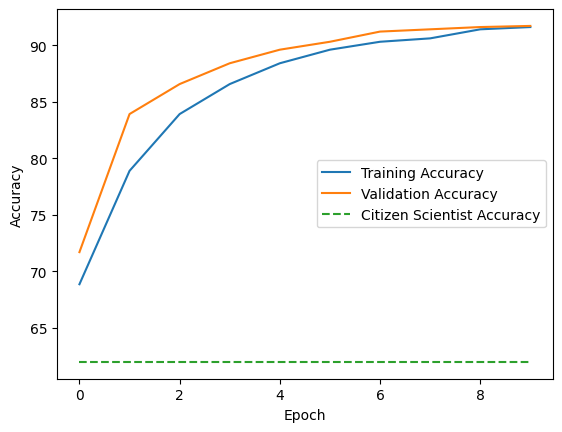

In [ ]:
plt.plot(epoch_hist, acc_hist_train, label="Training Accuracy")
plt.plot(epoch_hist, acc_hist_test, label="Validation Accuracy")
plt.plot(epoch_hist, [62, 62, 62, 62, 62, 62, 62, 62, 62, 62], '--', label="Citizen Scientist Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

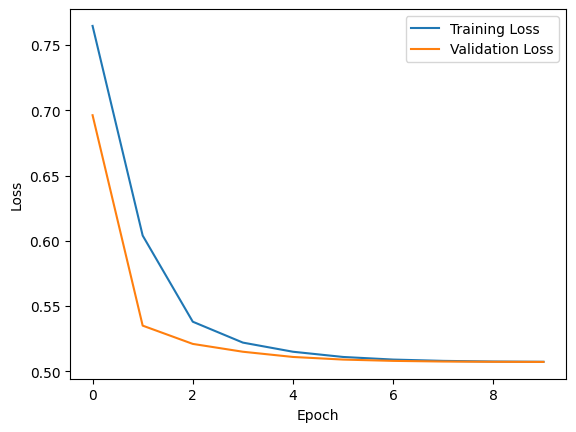

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch_hist, loss_hist_train, label="Training Loss")
plt.plot(epoch_hist, loss_hist_test, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model_0, train_loader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model_0, test_loader, loss_fn, optimizer, accuracy_fn, device)
  state = {
      'epoch': 3,
      'state_dict': model_0.state_dict(),
      'optimizer': optimizer.state_dict(),
  }
  torch.save(state, '/content/drive/MyDrive/galaxy_classifier/model_state')
  del state
  gc.collect()

train_time_end = timer()
time_elapsed = print_train_time(start=train_time_start, end=train_time_end, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------


0it [00:00, ?it/s]

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters())

In [ ]:
torch.cuda.empty_cache()

In [ ]:
gc.collect()

13531

In [ ]:
state = torch.load('/content/drive/MyDrive/galaxy_classifier/model_state')
model_1.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])
del state
gc.collect()
torch.cuda.empty_cache()

## Model training times + Accuracies



*   custom arch. with image size of 128px: 65% acc in 3 epochs w/ train time of 64525s (5 hours per epoch) (minimal data augmentation)
*   ResNet 34 with image size of 128px (no channel splitting): TBD



In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start = timer()

epochs = 6
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model_1, train_loader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model_1, test_loader, loss_fn, optimizer, accuracy_fn, device)
  state = {
      'epoch': 3,
      'state_dict': model_1.state_dict(),
      'optimizer': optimizer.state_dict(),
  }

  torch.save(state, '/content/drive/MyDrive/galaxy_classifier/model_state')
  del state
  gc.collect()

train_time_end = timer()
time_elapsed = print_train_time(start=train_time_start, end=train_time_end, device=device)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
-------


NameError: ignored